# 0. Configuration

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

In [3]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])

In [4]:
import pandas as pd
import numpy as np
import torch
import json

from transformers import AutoTokenizer, AutoConfig, AutoModel
from transformers import AutoModelForSequenceClassification
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.losses import cosine_similarity
from tensorflow import keras
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from pprint import pprint
from tensorflow.keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt

2022-06-07 11:53:07.159956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-07 11:53:07.870208: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4096 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:a6:00.0, compute capability: 6.1


# 1. Data and Model Loading

## 1-1. Data Loading

### FinPhrase

In [5]:
# data_fpath = './data/FinancialPhraseBank-v1.0/Sentences_50Agree.txt'

In [6]:
# with open(data_fpath, 'rb') as file:
#     data = file.read()
# data = data.decode('utf-8', 'ignore')
# data = data.split('\r\n')[:-1]
# print('Number of total data: %d\n' % len(data))
# print('Data examples:')
# print(data[:2])

In [7]:
# titles = [line.split('@')[0] for line in data]
# labels = [line.split('@')[1] for line in data]
# print('Title examples:')
# print(titles[:2])
# print('\nLabel examples')
# print(labels[:2])

In [8]:
# label_list = ['positive', 'negative', 'neutral']
# Y = tf.keras.layers.StringLookup(vocabulary=label_list,
#                                  num_oov_indices=0, output_mode='one_hot')(labels)

### SemEval 2017 Task 5

In [9]:
data_fpath = './data/Headline_Trainingdata.json'

In [10]:
with open(data_fpath, 'r', encoding='utf-8') as file:
    data = json.load(file)

print('Number of total data: %d\n' % len(data))
print('Data examples:')
pprint(data[:2])

Number of total data: 1142

Data examples:
[{'company': 'Morrisons',
  'id': 2,
  'sentiment': 0.43,
  'title': 'Morrisons book second consecutive quarter of sales growth'},
 {'company': 'IMI',
  'id': 3,
  'sentiment': -0.344,
  'title': 'IMI posts drop in first-quarter organic revenue; warns on full '
           'year'}]


In [11]:
ids = []
companies = []
titles = []
sentiments = []
for i in range(len(data)):
    ids.append(data[i]['id'])
    companies.append(data[i]['company'])
    titles.append(data[i]['title'])
    sentiments.append(data[i]['sentiment'])

## 1-2. FinBERT Model Loading

In [12]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
config = AutoConfig.from_pretrained('ProsusAI/finbert',
                                    output_hidden_states=True,
                                    output_attentions=True)
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", config=config)

## 1-3. Vectorization to Tensorflow

In [13]:
encoded_input = tokenizer(titles, padding=True, return_tensors='pt')

In [14]:
%%time
with torch.no_grad():
    outputs = model(**encoded_input)

CPU times: user 2min 54s, sys: 57.5 s, total: 3min 52s
Wall time: 6.46 s


# 2. Data Exploration

## 2-1. Statistics and Visualization

### Distribution Histogram

(array([  8.,  14.,  28.,  31.,  45.,  54.,  94.,  68.,  63.,  46., 108.,
        115., 154., 127.,  83.,  49.,  26.,  16.,   7.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

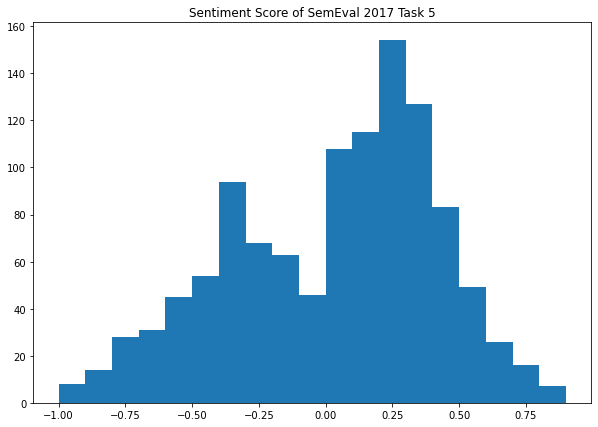

In [16]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Sentiment Score of SemEval 2017 Task 5')
ax.hist(np.array(sentiments), bins=np.arange(-1, 1, 0.1))

In [28]:
sentiments_pos = np.array(sentiments)[tf.math.argmax(outputs.logits, axis=1) == 0]
sentiments_neg = np.array(sentiments)[tf.math.argmax(outputs.logits, axis=1) == 1]
sentiments_neu = np.array(sentiments)[tf.math.argmax(outputs.logits, axis=1) == 2]

In [35]:
print('Average Sentiment Score:')
print('Positive Samples: %.4f' % np.mean(sentiments_pos))
print('Negative Samples: %.4f' % np.mean(sentiments_neg))
print('Neutral Samples: %.4f' % np.mean(sentiments_neu))

Average Sentiment Score:
Positive Samples: 0.3151
Negative Samples: -0.3175
Neutral Samples: 0.1080


(array([ 1.,  1.,  4.,  5.,  2.,  1.,  7.,  9.,  5.,  3.,  7., 20., 53.,
        63., 47., 36., 18., 14.,  6.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

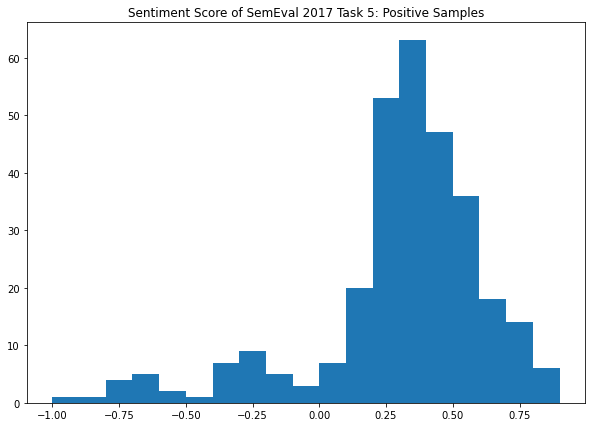

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Sentiment Score of SemEval 2017 Task 5: Positive Samples')
ax.hist(np.array(sentiments_pos), bins=np.arange(-1, 1, 0.1))

(array([ 6., 10., 23., 24., 35., 45., 70., 42., 27., 14., 17., 10., 15.,
         5.,  7.,  4.,  2.,  0.,  0.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

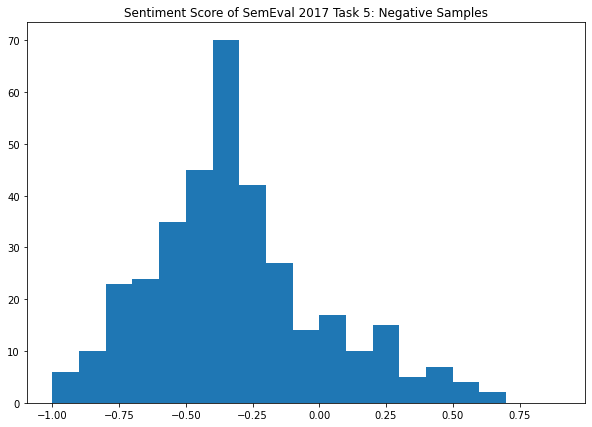

In [30]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Sentiment Score of SemEval 2017 Task 5: Negative Samples')
ax.hist(np.array(sentiments_neg), bins=np.arange(-1, 1, 0.1))

(array([ 1.,  3.,  1.,  2.,  8.,  8., 17., 17., 31., 29., 84., 85., 86.,
        59., 29.,  9.,  6.,  2.,  1.]),
 array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
        -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
        -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
         2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
         6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01]),
 <BarContainer object of 19 artists>)

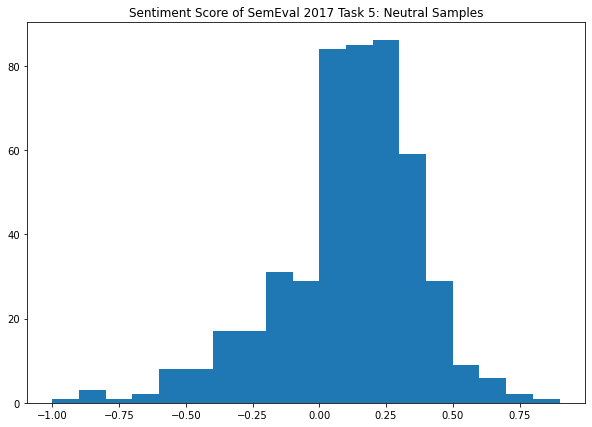

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('Sentiment Score of SemEval 2017 Task 5: Neutral Samples')
ax.hist(np.array(sentiments_neu), bins=np.arange(-1, 1, 0.1))

# 2. Experiments

## 2-1. Layer-wise Classification Performance

### Model build

In [77]:
probe_model = keras.Sequential()
probe_model.add(keras.Input(shape=(outputs.hidden_states[-1].shape[-1])))
probe_model.add(Dense(1, activation='tanh', name='output_layer'))
print((probe_model.summary()))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 output_layer (Dense)        (None, 1)                 769       
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None


In [78]:
probe_model.save_weights('probe_model_init.h5')

In [79]:
probe_model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['mean_squared_error', 'cosine_similarity'])

### Training Regression model

In [80]:
exp_name = '20220607_finbert_sentiment_layer_semeval'

In [81]:
X = tf.convert_to_tensor(outputs.hidden_states[-1])[:, 0, :]
Y = np.array(sentiments)
batch_size = len(X)

In [82]:
probe_model.load_weights('probe_model_init.h5')
ckp_path = exp_name + '/data/cp-{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(filepath=ckp_path, verbose=False,
                              save_weights_only=True, save_freq=100)
probe_model.save_weights(ckp_path.format(epoch=0))
history = probe_model.fit(X, Y, epochs=1000, batch_size=batch_size, verbose=True,
                          validation_split=0.3, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - 1s 734ms/step - loss: 0.6719 - mean_squared_error: 0.6719 - cosine_similarity: -0.2053 - val_loss: 0.6282 - val_mean_squared_error: 0.6282 - val_cosine_similarity: -0.1633
Epoch 2/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.5803 - mean_squared_error: 0.5803 - cosine_similarity: -0.1126 - val_loss: 0.5332 - val_mean_squared_error: 0.5332 - val_cosine_similarity: -0.0700
Epoch 3/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.4859 - mean_squared_error: 0.4859 - cosine_similarity: -0.0601 - val_loss: 0.4457 - val_mean_squared_error: 0.4457 - val_cosine_similarity: 0.0700
Epoch 4/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.3972 - mean_squared_error: 0.3972 - cosine_similarity: 0.0676 - val_loss: 0.3760 - val_mean_squared_error: 0.3760 - val_cosine_similarity: 0.2391
Epoch 5/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.3257 - mean_squared_error: 0.3257 -

Epoch 38/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.1367 - mean_squared_error: 0.1367 - cosine_similarity: 0.5156 - val_loss: 0.1592 - val_mean_squared_error: 0.1592 - val_cosine_similarity: 0.4665
Epoch 39/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.1335 - mean_squared_error: 0.1335 - cosine_similarity: 0.5382 - val_loss: 0.1568 - val_mean_squared_error: 0.1568 - val_cosine_similarity: 0.4723
Epoch 40/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.1316 - mean_squared_error: 0.1316 - cosine_similarity: 0.5432 - val_loss: 0.1554 - val_mean_squared_error: 0.1554 - val_cosine_similarity: 0.4956
Epoch 41/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.1304 - mean_squared_error: 0.1304 - cosine_similarity: 0.5507 - val_loss: 0.1547 - val_mean_squared_error: 0.1547 - val_cosine_similarity: 0.4898
Epoch 42/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - 

Epoch 75/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0903 - mean_squared_error: 0.0903 - cosine_similarity: 0.6083 - val_loss: 0.1289 - val_mean_squared_error: 0.1289 - val_cosine_similarity: 0.4956
Epoch 76/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0896 - mean_squared_error: 0.0896 - cosine_similarity: 0.6108 - val_loss: 0.1284 - val_mean_squared_error: 0.1284 - val_cosine_similarity: 0.4956
Epoch 77/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0889 - mean_squared_error: 0.0889 - cosine_similarity: 0.6083 - val_loss: 0.1277 - val_mean_squared_error: 0.1277 - val_cosine_similarity: 0.4956
Epoch 78/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0881 - mean_squared_error: 0.0881 - cosine_similarity: 0.6083 - val_loss: 0.1271 - val_mean_squared_error: 0.1271 - val_cosine_similarity: 0.4898
Epoch 79/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0874 - mean_squared_error: 0.0874 - 

Epoch 112/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0698 - mean_squared_error: 0.0698 - cosine_similarity: 0.6608 - val_loss: 0.1136 - val_mean_squared_error: 0.1136 - val_cosine_similarity: 0.5598
Epoch 113/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0694 - mean_squared_error: 0.0694 - cosine_similarity: 0.6633 - val_loss: 0.1133 - val_mean_squared_error: 0.1133 - val_cosine_similarity: 0.5598
Epoch 114/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0690 - mean_squared_error: 0.0690 - cosine_similarity: 0.6633 - val_loss: 0.1130 - val_mean_squared_error: 0.1130 - val_cosine_similarity: 0.5656
Epoch 115/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0685 - mean_squared_error: 0.0685 - cosine_similarity: 0.6658 - val_loss: 0.1128 - val_mean_squared_error: 0.1128 - val_cosine_similarity: 0.5714
Epoch 116/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0681 - mean_squared_error: 0.06

Epoch 149/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - cosine_similarity: 0.7109 - val_loss: 0.1053 - val_mean_squared_error: 0.1053 - val_cosine_similarity: 0.5598
Epoch 150/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - cosine_similarity: 0.7109 - val_loss: 0.1051 - val_mean_squared_error: 0.1051 - val_cosine_similarity: 0.5539
Epoch 151/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - cosine_similarity: 0.7134 - val_loss: 0.1050 - val_mean_squared_error: 0.1050 - val_cosine_similarity: 0.5539
Epoch 152/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0561 - mean_squared_error: 0.0561 - cosine_similarity: 0.7134 - val_loss: 0.1048 - val_mean_squared_error: 0.1048 - val_cosine_similarity: 0.5481
Epoch 153/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0558 - mean_squared_error: 0.05

Epoch 186/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0482 - mean_squared_error: 0.0482 - cosine_similarity: 0.7459 - val_loss: 0.1002 - val_mean_squared_error: 0.1002 - val_cosine_similarity: 0.5831
Epoch 187/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0480 - mean_squared_error: 0.0480 - cosine_similarity: 0.7484 - val_loss: 0.1001 - val_mean_squared_error: 0.1001 - val_cosine_similarity: 0.5831
Epoch 188/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0478 - mean_squared_error: 0.0478 - cosine_similarity: 0.7484 - val_loss: 0.1000 - val_mean_squared_error: 0.1000 - val_cosine_similarity: 0.5831
Epoch 189/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0476 - mean_squared_error: 0.0476 - cosine_similarity: 0.7509 - val_loss: 0.0999 - val_mean_squared_error: 0.0999 - val_cosine_similarity: 0.5831
Epoch 190/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0474 - mean_squared_error: 0.04

Epoch 223/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - cosine_similarity: 0.7660 - val_loss: 0.0970 - val_mean_squared_error: 0.0970 - val_cosine_similarity: 0.5889
Epoch 224/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - cosine_similarity: 0.7710 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - val_cosine_similarity: 0.5889
Epoch 225/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - cosine_similarity: 0.7710 - val_loss: 0.0969 - val_mean_squared_error: 0.0969 - val_cosine_similarity: 0.5948
Epoch 226/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - cosine_similarity: 0.7710 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_cosine_similarity: 0.5948
Epoch 227/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0415 - mean_squared_error: 0.04

Epoch 260/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - cosine_similarity: 0.7910 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_cosine_similarity: 0.6006
Epoch 261/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - cosine_similarity: 0.7910 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_cosine_similarity: 0.6064
Epoch 262/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0373 - mean_squared_error: 0.0373 - cosine_similarity: 0.7935 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - val_cosine_similarity: 0.6064
Epoch 263/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - cosine_similarity: 0.7935 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - val_cosine_similarity: 0.6064
Epoch 264/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0370 - mean_squared_error: 0.03

Epoch 297/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0340 - mean_squared_error: 0.0340 - cosine_similarity: 0.8010 - val_loss: 0.0938 - val_mean_squared_error: 0.0938 - val_cosine_similarity: 0.6122
Epoch 298/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - cosine_similarity: 0.8010 - val_loss: 0.0938 - val_mean_squared_error: 0.0938 - val_cosine_similarity: 0.6122
Epoch 299/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - cosine_similarity: 0.8010 - val_loss: 0.0938 - val_mean_squared_error: 0.0938 - val_cosine_similarity: 0.6122
Epoch 300/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - cosine_similarity: 0.8010 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_cosine_similarity: 0.6122
Epoch 301/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0337 - mean_squared_error: 0.03

Epoch 334/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - cosine_similarity: 0.8085 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - val_cosine_similarity: 0.6122
Epoch 335/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - cosine_similarity: 0.8085 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - val_cosine_similarity: 0.6122
Epoch 336/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0311 - mean_squared_error: 0.0311 - cosine_similarity: 0.8085 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - val_cosine_similarity: 0.6122
Epoch 337/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0310 - mean_squared_error: 0.0310 - cosine_similarity: 0.8085 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - val_cosine_similarity: 0.6122
Epoch 338/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0310 - mean_squared_error: 0.03

Epoch 371/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0290 - mean_squared_error: 0.0290 - cosine_similarity: 0.8135 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6064
Epoch 372/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - cosine_similarity: 0.8135 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6064
Epoch 373/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - cosine_similarity: 0.8135 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6064
Epoch 374/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - cosine_similarity: 0.8135 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6064
Epoch 375/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0288 - mean_squared_error: 0.02

Epoch 408/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - cosine_similarity: 0.8160 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6122
Epoch 409/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0271 - mean_squared_error: 0.0271 - cosine_similarity: 0.8160 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6122
Epoch 410/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - cosine_similarity: 0.8160 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6122
Epoch 411/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0270 - mean_squared_error: 0.0270 - cosine_similarity: 0.8160 - val_loss: 0.0929 - val_mean_squared_error: 0.0929 - val_cosine_similarity: 0.6181
Epoch 412/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0269 - mean_squared_error: 0.02

Epoch 445/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - cosine_similarity: 0.8160 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - val_cosine_similarity: 0.6122
Epoch 446/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - cosine_similarity: 0.8160 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - val_cosine_similarity: 0.6122
Epoch 447/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0255 - mean_squared_error: 0.0255 - cosine_similarity: 0.8185 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - val_cosine_similarity: 0.6122
Epoch 448/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0254 - mean_squared_error: 0.0254 - cosine_similarity: 0.8185 - val_loss: 0.0931 - val_mean_squared_error: 0.0931 - val_cosine_similarity: 0.6122
Epoch 449/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0254 - mean_squared_error: 0.02

Epoch 482/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - cosine_similarity: 0.8235 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_cosine_similarity: 0.6064
Epoch 483/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0242 - mean_squared_error: 0.0242 - cosine_similarity: 0.8235 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_cosine_similarity: 0.6006
Epoch 484/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - cosine_similarity: 0.8235 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_cosine_similarity: 0.5948
Epoch 485/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - cosine_similarity: 0.8210 - val_loss: 0.0933 - val_mean_squared_error: 0.0933 - val_cosine_similarity: 0.5948
Epoch 486/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0241 - mean_squared_error: 0.02

Epoch 519/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - cosine_similarity: 0.8260 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_cosine_similarity: 0.5948
Epoch 520/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - cosine_similarity: 0.8260 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_cosine_similarity: 0.5948
Epoch 521/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0230 - mean_squared_error: 0.0230 - cosine_similarity: 0.8260 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_cosine_similarity: 0.5948
Epoch 522/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - cosine_similarity: 0.8260 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_cosine_similarity: 0.5948
Epoch 523/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0229 - mean_squared_error: 0.02

Epoch 556/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - cosine_similarity: 0.8285 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_cosine_similarity: 0.6006
Epoch 557/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - cosine_similarity: 0.8285 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_cosine_similarity: 0.6006
Epoch 558/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - cosine_similarity: 0.8285 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_cosine_similarity: 0.6006
Epoch 559/1000
1/1 [==============================] - 0s 71ms/step - loss: 0.0219 - mean_squared_error: 0.0219 - cosine_similarity: 0.8285 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_cosine_similarity: 0.6006
Epoch 560/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0219 - mean_squared_error: 0.02

Epoch 593/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - cosine_similarity: 0.8335 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_cosine_similarity: 0.6006
Epoch 594/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - cosine_similarity: 0.8335 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_cosine_similarity: 0.6006
Epoch 595/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - cosine_similarity: 0.8335 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_cosine_similarity: 0.6006
Epoch 596/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - cosine_similarity: 0.8335 - val_loss: 0.0945 - val_mean_squared_error: 0.0945 - val_cosine_similarity: 0.6006
Epoch 597/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0210 - mean_squared_error: 0.02

Epoch 630/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - cosine_similarity: 0.8436 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - val_cosine_similarity: 0.5948
Epoch 631/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0203 - mean_squared_error: 0.0203 - cosine_similarity: 0.8436 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - val_cosine_similarity: 0.5948
Epoch 632/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - cosine_similarity: 0.8436 - val_loss: 0.0949 - val_mean_squared_error: 0.0949 - val_cosine_similarity: 0.5948
Epoch 633/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - cosine_similarity: 0.8436 - val_loss: 0.0950 - val_mean_squared_error: 0.0950 - val_cosine_similarity: 0.5948
Epoch 634/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0202 - mean_squared_error: 0.02

Epoch 667/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - cosine_similarity: 0.8461 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_cosine_similarity: 0.6064
Epoch 668/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - cosine_similarity: 0.8461 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_cosine_similarity: 0.6064
Epoch 669/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - cosine_similarity: 0.8461 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_cosine_similarity: 0.6064
Epoch 670/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - cosine_similarity: 0.8461 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_cosine_similarity: 0.6064
Epoch 671/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0195 - mean_squared_error: 0.01

Epoch 704/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - cosine_similarity: 0.8461 - val_loss: 0.0958 - val_mean_squared_error: 0.0958 - val_cosine_similarity: 0.6006
Epoch 705/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0189 - mean_squared_error: 0.0189 - cosine_similarity: 0.8461 - val_loss: 0.0959 - val_mean_squared_error: 0.0959 - val_cosine_similarity: 0.6006
Epoch 706/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - cosine_similarity: 0.8461 - val_loss: 0.0959 - val_mean_squared_error: 0.0959 - val_cosine_similarity: 0.6006
Epoch 707/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - cosine_similarity: 0.8461 - val_loss: 0.0959 - val_mean_squared_error: 0.0959 - val_cosine_similarity: 0.6006
Epoch 708/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0188 - mean_squared_error: 0.01

Epoch 741/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - cosine_similarity: 0.8486 - val_loss: 0.0963 - val_mean_squared_error: 0.0963 - val_cosine_similarity: 0.6006
Epoch 742/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - cosine_similarity: 0.8486 - val_loss: 0.0963 - val_mean_squared_error: 0.0963 - val_cosine_similarity: 0.5948
Epoch 743/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - cosine_similarity: 0.8486 - val_loss: 0.0963 - val_mean_squared_error: 0.0963 - val_cosine_similarity: 0.5948
Epoch 744/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - cosine_similarity: 0.8486 - val_loss: 0.0964 - val_mean_squared_error: 0.0964 - val_cosine_similarity: 0.5948
Epoch 745/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0182 - mean_squared_error: 0.01

Epoch 778/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - cosine_similarity: 0.8511 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_cosine_similarity: 0.5889
Epoch 779/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - cosine_similarity: 0.8511 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_cosine_similarity: 0.5889
Epoch 780/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - cosine_similarity: 0.8511 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_cosine_similarity: 0.5889
Epoch 781/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0177 - mean_squared_error: 0.0177 - cosine_similarity: 0.8511 - val_loss: 0.0968 - val_mean_squared_error: 0.0968 - val_cosine_similarity: 0.5889
Epoch 782/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0177 - mean_squared_error: 0.01

Epoch 815/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - cosine_similarity: 0.8461 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_cosine_similarity: 0.5889
Epoch 816/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - cosine_similarity: 0.8461 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_cosine_similarity: 0.5889
Epoch 817/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - cosine_similarity: 0.8461 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_cosine_similarity: 0.5948
Epoch 818/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - cosine_similarity: 0.8461 - val_loss: 0.0973 - val_mean_squared_error: 0.0973 - val_cosine_similarity: 0.5948
Epoch 819/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0172 - mean_squared_error: 0.01

Epoch 852/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - cosine_similarity: 0.8461 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_cosine_similarity: 0.5948
Epoch 853/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - cosine_similarity: 0.8461 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_cosine_similarity: 0.5948
Epoch 854/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - cosine_similarity: 0.8461 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_cosine_similarity: 0.5948
Epoch 855/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0167 - mean_squared_error: 0.0167 - cosine_similarity: 0.8461 - val_loss: 0.0978 - val_mean_squared_error: 0.0978 - val_cosine_similarity: 0.5948
Epoch 856/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0167 - mean_squared_error: 0.01

Epoch 889/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - cosine_similarity: 0.8511 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - val_cosine_similarity: 0.6006
Epoch 890/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - cosine_similarity: 0.8511 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - val_cosine_similarity: 0.6006
Epoch 891/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - cosine_similarity: 0.8511 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - val_cosine_similarity: 0.6006
Epoch 892/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - cosine_similarity: 0.8511 - val_loss: 0.0983 - val_mean_squared_error: 0.0983 - val_cosine_similarity: 0.6006
Epoch 893/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0162 - mean_squared_error: 0.01

Epoch 926/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - cosine_similarity: 0.8511 - val_loss: 0.0988 - val_mean_squared_error: 0.0988 - val_cosine_similarity: 0.6006
Epoch 927/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - cosine_similarity: 0.8511 - val_loss: 0.0988 - val_mean_squared_error: 0.0988 - val_cosine_similarity: 0.6006
Epoch 928/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - cosine_similarity: 0.8511 - val_loss: 0.0988 - val_mean_squared_error: 0.0988 - val_cosine_similarity: 0.6006
Epoch 929/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - cosine_similarity: 0.8511 - val_loss: 0.0989 - val_mean_squared_error: 0.0989 - val_cosine_similarity: 0.6006
Epoch 930/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0158 - mean_squared_error: 0.01

Epoch 963/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - cosine_similarity: 0.8561 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - val_cosine_similarity: 0.6064
Epoch 964/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - cosine_similarity: 0.8561 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - val_cosine_similarity: 0.6064
Epoch 965/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - cosine_similarity: 0.8561 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - val_cosine_similarity: 0.6064
Epoch 966/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - cosine_similarity: 0.8561 - val_loss: 0.0994 - val_mean_squared_error: 0.0994 - val_cosine_similarity: 0.6064
Epoch 967/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0154 - mean_squared_error: 0.01

Epoch 1000/1000
1/1 [==============================] - 0s 78ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - cosine_similarity: 0.8586 - val_loss: 0.0999 - val_mean_squared_error: 0.0999 - val_cosine_similarity: 0.6064


In [107]:
print('MSE\t| Epoch\t|Cos\t| Epoch\t| Val MSE\t| Epoch\t| Val Cos\t| Epoch')
train_mse = np.min(np.array(history.history['mean_squared_error']))
train_epoch = np.argmin(np.array(history.history['mean_squared_error']))
train_cos = np.max(np.array(history.history['cosine_similarity']))
train_epoch_cos = np.argmax(np.array(history.history['cosine_similarity']))
val_mse = np.min(np.array(history.history['val_mean_squared_error']))
val_epoch_mse = np.argmin(np.array(history.history['val_mean_squared_error']))
val_cos = np.max(np.array(history.history['val_cosine_similarity']))
val_epoch_cos = np.argmax(np.array(history.history['val_cosine_similarity']))
print('%.4f\t| %d\t|%.4f\t| %d\t| %.4f\t| %d\t| %.4f\t| %d' %
      (train_mse, train_epoch, train_cos, train_epoch_cos,
       val_mse, val_epoch_mse, val_cos, val_epoch_cos))

MSE	| Epoch	|Cos	| Epoch	| Val MSE	| Epoch	| Val Cos	| Epoch
0.0151	| 999	|0.8586	| 997	| 0.0929	| 391	| 0.6181	| 285


### With dense layer

In [108]:
probe_model = keras.Sequential()
probe_model.add(keras.Input(shape=(outputs.hidden_states[-1].shape[-1])))
probe_model.add(Dense(256, activation='gelu', name='dense_layer'))
probe_model.add(Dropout(0.1, name='dropout_layer'))
probe_model.add(Dense(1, activation='tanh', name='output_layer'))
print((probe_model.summary()))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 256)               196864    
                                                                 
 dropout_layer (Dropout)     (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 197,121
Trainable params: 197,121
Non-trainable params: 0
_________________________________________________________________
None


In [109]:
probe_model.save_weights('probe_model_init.h5')

In [110]:
probe_model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['mean_squared_error', 'cosine_similarity'])

In [111]:
exp_name = '20220607_finbert_sentiment_layer_semeval_dense'

In [112]:
probe_model.load_weights('probe_model_init.h5')
ckp_path = exp_name + '/data/cp-{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(filepath=ckp_path, verbose=False,
                              save_weights_only=True, save_freq=100)
probe_model.save_weights(ckp_path.format(epoch=0))
history = probe_model.fit(X, Y, epochs=1000, batch_size=batch_size, verbose=True,
                          validation_split=0.3, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - 1s 644ms/step - loss: 0.3356 - mean_squared_error: 0.3356 - cosine_similarity: 0.2353 - val_loss: 0.6132 - val_mean_squared_error: 0.6132 - val_cosine_similarity: 0.0525
Epoch 2/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.6714 - mean_squared_error: 0.6714 - cosine_similarity: -0.0200 - val_loss: 0.4256 - val_mean_squared_error: 0.4256 - val_cosine_similarity: 0.4023
Epoch 3/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.4160 - mean_squared_error: 0.4160 - cosine_similarity: 0.3354 - val_loss: 0.4511 - val_mean_squared_error: 0.4511 - val_cosine_similarity: 0.6064
Epoch 4/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.4323 - mean_squared_error: 0.4323 - cosine_similarity: 0.6208 - val_loss: 0.4985 - val_mean_squared_error: 0.4985 - val_cosine_similarity: 0.6181
Epoch 5/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.4833 - mean_squared_error: 0.4833 - cos

Epoch 38/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.0629 - mean_squared_error: 0.0629 - cosine_similarity: 0.7234 - val_loss: 0.0940 - val_mean_squared_error: 0.0940 - val_cosine_similarity: 0.6414
Epoch 39/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - cosine_similarity: 0.7059 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_cosine_similarity: 0.5948
Epoch 40/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - cosine_similarity: 0.6984 - val_loss: 0.0974 - val_mean_squared_error: 0.0974 - val_cosine_similarity: 0.6006
Epoch 41/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0580 - mean_squared_error: 0.0580 - cosine_similarity: 0.6583 - val_loss: 0.0947 - val_mean_squared_error: 0.0947 - val_cosine_similarity: 0.5714
Epoch 42/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0571 - mean_squared_error: 0.0571 - 

Epoch 75/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - cosine_similarity: 0.8110 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6472
Epoch 76/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - cosine_similarity: 0.8461 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 77/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0210 - mean_squared_error: 0.0210 - cosine_similarity: 0.8486 - val_loss: 0.0763 - val_mean_squared_error: 0.0763 - val_cosine_similarity: 0.6414
Epoch 78/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - cosine_similarity: 0.8335 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_cosine_similarity: 0.6414
Epoch 79/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - 

Epoch 112/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - cosine_similarity: 0.8736 - val_loss: 0.0747 - val_mean_squared_error: 0.0747 - val_cosine_similarity: 0.6531
Epoch 113/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - cosine_similarity: 0.8711 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - val_cosine_similarity: 0.6531
Epoch 114/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - cosine_similarity: 0.8486 - val_loss: 0.0744 - val_mean_squared_error: 0.0744 - val_cosine_similarity: 0.6472
Epoch 115/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - cosine_similarity: 0.8736 - val_loss: 0.0745 - val_mean_squared_error: 0.0745 - val_cosine_similarity: 0.6531
Epoch 116/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0141 - mean_squared_error: 0.01

Epoch 149/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - cosine_similarity: 0.8811 - val_loss: 0.0763 - val_mean_squared_error: 0.0763 - val_cosine_similarity: 0.6589
Epoch 150/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - cosine_similarity: 0.8861 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6589
Epoch 151/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - cosine_similarity: 0.8836 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6589
Epoch 152/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0098 - mean_squared_error: 0.0098 - cosine_similarity: 0.8961 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6589
Epoch 153/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0095 - mean_squared_error: 0.00

Epoch 186/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - cosine_similarity: 0.8811 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6589
Epoch 187/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - cosine_similarity: 0.8861 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6589
Epoch 188/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - cosine_similarity: 0.8886 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6589
Epoch 189/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - cosine_similarity: 0.9011 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_cosine_similarity: 0.6531
Epoch 190/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0086 - mean_squared_error: 0.00

Epoch 223/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - cosine_similarity: 0.8911 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6589
Epoch 224/1000
1/1 [==============================] - 0s 42ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - cosine_similarity: 0.8886 - val_loss: 0.0766 - val_mean_squared_error: 0.0766 - val_cosine_similarity: 0.6472
Epoch 225/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - cosine_similarity: 0.9036 - val_loss: 0.0766 - val_mean_squared_error: 0.0766 - val_cosine_similarity: 0.6472
Epoch 226/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - cosine_similarity: 0.9086 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6414
Epoch 227/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0078 - mean_squared_error: 0.00

Epoch 260/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - cosine_similarity: 0.8986 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_cosine_similarity: 0.6531
Epoch 261/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0075 - mean_squared_error: 0.0075 - cosine_similarity: 0.9011 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6531
Epoch 262/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - cosine_similarity: 0.9086 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6531
Epoch 263/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - cosine_similarity: 0.8836 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_cosine_similarity: 0.6589
Epoch 264/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0070 - mean_squared_error: 0.00

Epoch 297/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - cosine_similarity: 0.8986 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6531
Epoch 298/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - cosine_similarity: 0.9111 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6531
Epoch 299/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - cosine_similarity: 0.8936 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6472
Epoch 300/1000
1/1 [==============================] - 0s 79ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - cosine_similarity: 0.8986 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 301/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0075 - mean_squared_error: 0.00

Epoch 334/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - cosine_similarity: 0.9011 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_cosine_similarity: 0.6472
Epoch 335/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - cosine_similarity: 0.9111 - val_loss: 0.0765 - val_mean_squared_error: 0.0765 - val_cosine_similarity: 0.6472
Epoch 336/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - cosine_similarity: 0.9161 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 337/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - cosine_similarity: 0.9086 - val_loss: 0.0766 - val_mean_squared_error: 0.0766 - val_cosine_similarity: 0.6531
Epoch 338/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0070 - mean_squared_error: 0.00

Epoch 371/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - cosine_similarity: 0.9111 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6414
Epoch 372/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - cosine_similarity: 0.8986 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6472
Epoch 373/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - cosine_similarity: 0.8986 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 374/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - cosine_similarity: 0.9061 - val_loss: 0.0768 - val_mean_squared_error: 0.0768 - val_cosine_similarity: 0.6472
Epoch 375/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0065 - mean_squared_error: 0.00

Epoch 408/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - cosine_similarity: 0.8961 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6414
Epoch 409/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - cosine_similarity: 0.9111 - val_loss: 0.0753 - val_mean_squared_error: 0.0753 - val_cosine_similarity: 0.6472
Epoch 410/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - cosine_similarity: 0.8986 - val_loss: 0.0753 - val_mean_squared_error: 0.0753 - val_cosine_similarity: 0.6414
Epoch 411/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - cosine_similarity: 0.9036 - val_loss: 0.0763 - val_mean_squared_error: 0.0763 - val_cosine_similarity: 0.6414
Epoch 412/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0064 - mean_squared_error: 0.00

Epoch 445/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_similarity: 0.9061 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6414
Epoch 446/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - cosine_similarity: 0.9262 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6414
Epoch 447/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - cosine_similarity: 0.8961 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6414
Epoch 448/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - cosine_similarity: 0.9136 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6414
Epoch 449/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0058 - mean_squared_error: 0.00

Epoch 482/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_similarity: 0.9086 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6472
Epoch 483/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - cosine_similarity: 0.9086 - val_loss: 0.0755 - val_mean_squared_error: 0.0755 - val_cosine_similarity: 0.6472
Epoch 484/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - cosine_similarity: 0.9061 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6472
Epoch 485/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - cosine_similarity: 0.9011 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_cosine_similarity: 0.6472
Epoch 486/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0058 - mean_squared_error: 0.00

Epoch 519/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.9136 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6414
Epoch 520/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - cosine_similarity: 0.9111 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6414
Epoch 521/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - cosine_similarity: 0.9086 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6414
Epoch 522/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_similarity: 0.8886 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6414
Epoch 523/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0058 - mean_squared_error: 0.00

Epoch 556/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - cosine_similarity: 0.9111 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6414
Epoch 557/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9237 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6472
Epoch 558/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - cosine_similarity: 0.9061 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6472
Epoch 559/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - cosine_similarity: 0.8936 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6472
Epoch 560/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0061 - mean_squared_error: 0.00

Epoch 593/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - cosine_similarity: 0.9136 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6414
Epoch 594/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.9212 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6472
Epoch 595/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_similarity: 0.9036 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6472
Epoch 596/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - cosine_similarity: 0.9086 - val_loss: 0.0754 - val_mean_squared_error: 0.0754 - val_cosine_similarity: 0.6472
Epoch 597/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0060 - mean_squared_error: 0.00

Epoch 630/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9036 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_cosine_similarity: 0.6472
Epoch 631/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9237 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 632/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - cosine_similarity: 0.9061 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6472
Epoch 633/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.8986 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6472
Epoch 634/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0055 - mean_squared_error: 0.00

Epoch 667/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9036 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6414
Epoch 668/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.9036 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6472
Epoch 669/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - cosine_similarity: 0.9036 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6472
Epoch 670/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9136 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_cosine_similarity: 0.6414
Epoch 671/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0058 - mean_squared_error: 0.00

Epoch 704/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_similarity: 0.9036 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6414
Epoch 705/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - cosine_similarity: 0.9061 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 706/1000
1/1 [==============================] - 0s 62ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - cosine_similarity: 0.9111 - val_loss: 0.0763 - val_mean_squared_error: 0.0763 - val_cosine_similarity: 0.6531
Epoch 707/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9287 - val_loss: 0.0764 - val_mean_squared_error: 0.0764 - val_cosine_similarity: 0.6472
Epoch 708/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0051 - mean_squared_error: 0.00

Epoch 741/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9111 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6531
Epoch 742/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.9061 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6531
Epoch 743/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9061 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6531
Epoch 744/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - cosine_similarity: 0.9212 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_cosine_similarity: 0.6531
Epoch 745/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0055 - mean_squared_error: 0.00

Epoch 778/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - cosine_similarity: 0.9136 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6472
Epoch 779/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9011 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6531
Epoch 780/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9136 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6589
Epoch 781/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - cosine_similarity: 0.9136 - val_loss: 0.0755 - val_mean_squared_error: 0.0755 - val_cosine_similarity: 0.6472
Epoch 782/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0058 - mean_squared_error: 0.00

Epoch 815/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9186 - val_loss: 0.0753 - val_mean_squared_error: 0.0753 - val_cosine_similarity: 0.6414
Epoch 816/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9111 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6414
Epoch 817/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9061 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6414
Epoch 818/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9262 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6414
Epoch 819/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0056 - mean_squared_error: 0.00

Epoch 852/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - cosine_similarity: 0.9036 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6472
Epoch 853/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9036 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6414
Epoch 854/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - cosine_similarity: 0.9036 - val_loss: 0.0751 - val_mean_squared_error: 0.0751 - val_cosine_similarity: 0.6531
Epoch 855/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9036 - val_loss: 0.0752 - val_mean_squared_error: 0.0752 - val_cosine_similarity: 0.6472
Epoch 856/1000
1/1 [==============================] - 0s 70ms/step - loss: 0.0053 - mean_squared_error: 0.00

Epoch 889/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - cosine_similarity: 0.9161 - val_loss: 0.0754 - val_mean_squared_error: 0.0754 - val_cosine_similarity: 0.6472
Epoch 890/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9237 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6472
Epoch 891/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - cosine_similarity: 0.9086 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6414
Epoch 892/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - cosine_similarity: 0.9086 - val_loss: 0.0759 - val_mean_squared_error: 0.0759 - val_cosine_similarity: 0.6414
Epoch 893/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0052 - mean_squared_error: 0.00

Epoch 926/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - cosine_similarity: 0.9061 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_cosine_similarity: 0.6472
Epoch 927/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9186 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_cosine_similarity: 0.6531
Epoch 928/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - cosine_similarity: 0.9086 - val_loss: 0.0762 - val_mean_squared_error: 0.0762 - val_cosine_similarity: 0.6472
Epoch 929/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9287 - val_loss: 0.0760 - val_mean_squared_error: 0.0760 - val_cosine_similarity: 0.6531
Epoch 930/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.0049 - mean_squared_error: 0.00

Epoch 963/1000
1/1 [==============================] - 0s 73ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9161 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_cosine_similarity: 0.6414
Epoch 964/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - cosine_similarity: 0.9161 - val_loss: 0.0755 - val_mean_squared_error: 0.0755 - val_cosine_similarity: 0.6472
Epoch 965/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - cosine_similarity: 0.9061 - val_loss: 0.0751 - val_mean_squared_error: 0.0751 - val_cosine_similarity: 0.6531
Epoch 966/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9011 - val_loss: 0.0752 - val_mean_squared_error: 0.0752 - val_cosine_similarity: 0.6472
Epoch 967/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0052 - mean_squared_error: 0.00

Epoch 1000/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - cosine_similarity: 0.9287 - val_loss: 0.0756 - val_mean_squared_error: 0.0756 - val_cosine_similarity: 0.6472


In [113]:
print('MSE\t| Epoch\t|Cos\t| Epoch\t| Val MSE\t| Epoch\t| Val Cos\t| Epoch')
train_mse = np.min(np.array(history.history['mean_squared_error']))
train_epoch = np.argmin(np.array(history.history['mean_squared_error']))
train_cos = np.max(np.array(history.history['cosine_similarity']))
train_epoch_cos = np.argmax(np.array(history.history['cosine_similarity']))
val_mse = np.min(np.array(history.history['val_mean_squared_error']))
val_epoch_mse = np.argmin(np.array(history.history['val_mean_squared_error']))
val_cos = np.max(np.array(history.history['val_cosine_similarity']))
val_epoch_cos = np.argmax(np.array(history.history['val_cosine_similarity']))
print('%.4f\t| %d\t|%.4f\t| %d\t| %.4f\t| %d\t| %.4f\t| %d' %
      (train_mse, train_epoch, train_cos, train_epoch_cos,
       val_mse, val_epoch_mse, val_cos, val_epoch_cos))

MSE	| Epoch	|Cos	| Epoch	| Val MSE	| Epoch	| Val Cos	| Epoch
0.0047	| 750	|0.9362	| 874	| 0.0743	| 107	| 0.6706	| 55


In [116]:
Y_pred = probe_model.predict(X)

36/36 [==============================] - 0s 2ms/step


In [137]:
Y

array([ 0.43 , -0.344,  0.34 , ..., -0.786,  0.494, -0.461])

In [139]:
np.empty?

In [150]:
Y_cls = np.empty(shape=Y.shape)
for i, y in enumerate(Y):
    if y > 0.3:
        Y_cls[i] = 0
    elif y < -0.3:
        Y_cls[i] = 1
    else:
        Y_cls[i] = 2
Y_cls = tf.one_hot(Y_cls, 3)

In [152]:
probe_model = keras.Sequential()
probe_model.add(keras.Input(shape=(outputs.hidden_states[-1].shape[-1])))
probe_model.add(Dense(256, activation='gelu', name='dense_layer'))
probe_model.add(Dropout(0.1, name='dropout_layer'))
probe_model.add(Dense(3, activation='softmax', name='output_layer'))
print((probe_model.summary()))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_layer (Dense)         (None, 256)               196864    
                                                                 
 dropout_layer (Dropout)     (None, 256)               0         
                                                                 
 output_layer (Dense)        (None, 3)                 771       
                                                                 
Total params: 197,635
Trainable params: 197,635
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
probe_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [154]:
probe_model.save_weights('probe_model_init.h5')

In [155]:
exp_name = '20220603_finbert_sentiment_layer_probe_nonlinear_cls'

In [156]:
probe_model.load_weights('probe_model_init.h5')
    
ckp_path = exp_name + '/data/cp-{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(filepath=ckp_path, verbose=False,
                              save_weights_only=True, save_freq=100)
probe_model.save_weights(ckp_path.format(epoch=0))
history = probe_model.fit(X, Y_cls, epochs=1000, batch_size=batch_size, verbose=True,
                          validation_split=0.3, callbacks=[cp_callback])

Epoch 1/1000
1/1 [==============================] - 1s 584ms/step - loss: 1.2885 - accuracy: 0.3755 - val_loss: 0.9016 - val_accuracy: 0.6210
Epoch 2/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.8542 - accuracy: 0.6483 - val_loss: 1.0054 - val_accuracy: 0.6239
Epoch 3/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.9034 - accuracy: 0.6558 - val_loss: 0.9801 - val_accuracy: 0.6356
Epoch 4/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.8537 - accuracy: 0.6746 - val_loss: 0.9141 - val_accuracy: 0.6385
Epoch 5/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.7867 - accuracy: 0.6896 - val_loss: 0.8654 - val_accuracy: 0.6297
Epoch 6/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.7489 - accuracy: 0.6821 - val_loss: 0.8332 - val_accuracy: 0.6385
Epoch 7/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.7092 - accuracy: 0.6934 - val_loss: 0.8019 - val_accuracy: 0.6443
Epoch 8/1000

Epoch 59/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.2409 - accuracy: 0.9262 - val_loss: 0.8193 - val_accuracy: 0.7085
Epoch 60/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.2321 - accuracy: 0.9374 - val_loss: 0.8249 - val_accuracy: 0.7085
Epoch 61/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.2281 - accuracy: 0.9324 - val_loss: 0.8291 - val_accuracy: 0.7055
Epoch 62/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.2222 - accuracy: 0.9274 - val_loss: 0.8337 - val_accuracy: 0.7055
Epoch 63/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.2211 - accuracy: 0.9337 - val_loss: 0.8388 - val_accuracy: 0.7055
Epoch 64/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.2136 - accuracy: 0.9362 - val_loss: 0.8428 - val_accuracy: 0.7114
Epoch 65/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.2135 - accuracy: 0.9337 - val_loss: 0.8446 - val_accuracy: 0.7172
Epoch 

1/1 [==============================] - 0s 39ms/step - loss: 0.0784 - accuracy: 0.9750 - val_loss: 1.1330 - val_accuracy: 0.6968
Epoch 117/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.0752 - accuracy: 0.9712 - val_loss: 1.1333 - val_accuracy: 0.6939
Epoch 118/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0702 - accuracy: 0.9775 - val_loss: 1.1347 - val_accuracy: 0.6910
Epoch 119/1000
1/1 [==============================] - 0s 45ms/step - loss: 0.0740 - accuracy: 0.9762 - val_loss: 1.1374 - val_accuracy: 0.6851
Epoch 120/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0774 - accuracy: 0.9750 - val_loss: 1.1452 - val_accuracy: 0.6939
Epoch 121/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.0693 - accuracy: 0.9812 - val_loss: 1.1584 - val_accuracy: 0.6968
Epoch 122/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.0706 - accuracy: 0.9775 - val_loss: 1.1640 - val_accuracy: 0.6968
Epoch 123/1000

1/1 [==============================] - 0s 50ms/step - loss: 0.0485 - accuracy: 0.9800 - val_loss: 1.3289 - val_accuracy: 0.7055
Epoch 174/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0479 - accuracy: 0.9800 - val_loss: 1.3323 - val_accuracy: 0.6997
Epoch 175/1000
1/1 [==============================] - 0s 67ms/step - loss: 0.0547 - accuracy: 0.9700 - val_loss: 1.3346 - val_accuracy: 0.7055
Epoch 176/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0536 - accuracy: 0.9787 - val_loss: 1.3359 - val_accuracy: 0.6939
Epoch 177/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0491 - accuracy: 0.9762 - val_loss: 1.3457 - val_accuracy: 0.6997
Epoch 178/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0482 - accuracy: 0.9750 - val_loss: 1.3612 - val_accuracy: 0.7114
Epoch 179/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0488 - accuracy: 0.9775 - val_loss: 1.3729 - val_accuracy: 0.7085
Epoch 180/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.0412 - accuracy: 0.9787 - val_loss: 1.4423 - val_accuracy: 0.7055
Epoch 231/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0423 - accuracy: 0.9800 - val_loss: 1.4418 - val_accuracy: 0.7026
Epoch 232/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0461 - accuracy: 0.9737 - val_loss: 1.4451 - val_accuracy: 0.7114
Epoch 233/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0411 - accuracy: 0.9787 - val_loss: 1.4496 - val_accuracy: 0.7085
Epoch 234/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0475 - accuracy: 0.9787 - val_loss: 1.4509 - val_accuracy: 0.7055
Epoch 235/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0422 - accuracy: 0.9775 - val_loss: 1.4516 - val_accuracy: 0.7026
Epoch 236/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0450 - accuracy: 0.9762 - val_loss: 1.4560 - val_accuracy: 0.7085
Epoch 237/1000

1/1 [==============================] - 0s 54ms/step - loss: 0.0399 - accuracy: 0.9762 - val_loss: 1.5353 - val_accuracy: 0.7085
Epoch 288/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0360 - accuracy: 0.9812 - val_loss: 1.5405 - val_accuracy: 0.7085
Epoch 289/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0447 - accuracy: 0.9750 - val_loss: 1.5329 - val_accuracy: 0.7026
Epoch 290/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0413 - accuracy: 0.9750 - val_loss: 1.5297 - val_accuracy: 0.7055
Epoch 291/1000
1/1 [==============================] - 0s 63ms/step - loss: 0.0362 - accuracy: 0.9800 - val_loss: 1.5302 - val_accuracy: 0.7085
Epoch 292/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0397 - accuracy: 0.9737 - val_loss: 1.5298 - val_accuracy: 0.7026
Epoch 293/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0376 - accuracy: 0.9825 - val_loss: 1.5299 - val_accuracy: 0.7026
Epoch 294/1000

1/1 [==============================] - 0s 56ms/step - loss: 0.0395 - accuracy: 0.9750 - val_loss: 1.6239 - val_accuracy: 0.7026
Epoch 345/1000
1/1 [==============================] - 0s 48ms/step - loss: 0.0380 - accuracy: 0.9812 - val_loss: 1.6152 - val_accuracy: 0.6968
Epoch 346/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0365 - accuracy: 0.9787 - val_loss: 1.6067 - val_accuracy: 0.7026
Epoch 347/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0357 - accuracy: 0.9825 - val_loss: 1.6017 - val_accuracy: 0.7026
Epoch 348/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0403 - accuracy: 0.9712 - val_loss: 1.6014 - val_accuracy: 0.6997
Epoch 349/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0387 - accuracy: 0.9775 - val_loss: 1.6071 - val_accuracy: 0.6997
Epoch 350/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0376 - accuracy: 0.9787 - val_loss: 1.6154 - val_accuracy: 0.7055
Epoch 351/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.0357 - accuracy: 0.9825 - val_loss: 1.6505 - val_accuracy: 0.7114
Epoch 402/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0338 - accuracy: 0.9787 - val_loss: 1.6394 - val_accuracy: 0.7055
Epoch 403/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0373 - accuracy: 0.9762 - val_loss: 1.6300 - val_accuracy: 0.7055
Epoch 404/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0354 - accuracy: 0.9787 - val_loss: 1.6197 - val_accuracy: 0.6997
Epoch 405/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0374 - accuracy: 0.9762 - val_loss: 1.6150 - val_accuracy: 0.7026
Epoch 406/1000
1/1 [==============================] - 0s 66ms/step - loss: 0.0358 - accuracy: 0.9787 - val_loss: 1.6174 - val_accuracy: 0.7026
Epoch 407/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0336 - accuracy: 0.9825 - val_loss: 1.6249 - val_accuracy: 0.6997
Epoch 408/1000

1/1 [==============================] - 0s 57ms/step - loss: 0.0363 - accuracy: 0.9812 - val_loss: 1.6844 - val_accuracy: 0.7085
Epoch 459/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0377 - accuracy: 0.9812 - val_loss: 1.6821 - val_accuracy: 0.7055
Epoch 460/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0349 - accuracy: 0.9837 - val_loss: 1.6824 - val_accuracy: 0.7085
Epoch 461/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0347 - accuracy: 0.9825 - val_loss: 1.6866 - val_accuracy: 0.7055
Epoch 462/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0397 - accuracy: 0.9775 - val_loss: 1.6869 - val_accuracy: 0.7085
Epoch 463/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0379 - accuracy: 0.9737 - val_loss: 1.6793 - val_accuracy: 0.7055
Epoch 464/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0339 - accuracy: 0.9750 - val_loss: 1.6686 - val_accuracy: 0.7114
Epoch 465/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.0367 - accuracy: 0.9750 - val_loss: 1.7347 - val_accuracy: 0.7114
Epoch 516/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0367 - accuracy: 0.9750 - val_loss: 1.7327 - val_accuracy: 0.7085
Epoch 517/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0371 - accuracy: 0.9750 - val_loss: 1.7319 - val_accuracy: 0.7085
Epoch 518/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0324 - accuracy: 0.9862 - val_loss: 1.7302 - val_accuracy: 0.7055
Epoch 519/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0371 - accuracy: 0.9762 - val_loss: 1.7278 - val_accuracy: 0.7085
Epoch 520/1000
1/1 [==============================] - 0s 44ms/step - loss: 0.0354 - accuracy: 0.9787 - val_loss: 1.7199 - val_accuracy: 0.7114
Epoch 521/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0367 - accuracy: 0.9762 - val_loss: 1.7127 - val_accuracy: 0.7085
Epoch 522/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.0358 - accuracy: 0.9762 - val_loss: 1.7456 - val_accuracy: 0.7055
Epoch 573/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0345 - accuracy: 0.9787 - val_loss: 1.7447 - val_accuracy: 0.7026
Epoch 574/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0371 - accuracy: 0.9762 - val_loss: 1.7470 - val_accuracy: 0.7055
Epoch 575/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0362 - accuracy: 0.9787 - val_loss: 1.7537 - val_accuracy: 0.7055
Epoch 576/1000
1/1 [==============================] - 0s 72ms/step - loss: 0.0356 - accuracy: 0.9750 - val_loss: 1.7622 - val_accuracy: 0.6997
Epoch 577/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0371 - accuracy: 0.9762 - val_loss: 1.7644 - val_accuracy: 0.6997
Epoch 578/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0361 - accuracy: 0.9750 - val_loss: 1.7530 - val_accuracy: 0.7055
Epoch 579/1000

1/1 [==============================] - 0s 54ms/step - loss: 0.0349 - accuracy: 0.9775 - val_loss: 1.7778 - val_accuracy: 0.7055
Epoch 630/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0357 - accuracy: 0.9775 - val_loss: 1.7757 - val_accuracy: 0.7055
Epoch 631/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0368 - accuracy: 0.9737 - val_loss: 1.7787 - val_accuracy: 0.6997
Epoch 632/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0353 - accuracy: 0.9787 - val_loss: 1.7833 - val_accuracy: 0.7026
Epoch 633/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0359 - accuracy: 0.9737 - val_loss: 1.7866 - val_accuracy: 0.7026
Epoch 634/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0359 - accuracy: 0.9750 - val_loss: 1.7934 - val_accuracy: 0.7026
Epoch 635/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0366 - accuracy: 0.9775 - val_loss: 1.7961 - val_accuracy: 0.7026
Epoch 636/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.0342 - accuracy: 0.9750 - val_loss: 1.8136 - val_accuracy: 0.7114
Epoch 687/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0344 - accuracy: 0.9750 - val_loss: 1.8173 - val_accuracy: 0.7114
Epoch 688/1000
1/1 [==============================] - 0s 65ms/step - loss: 0.0357 - accuracy: 0.9775 - val_loss: 1.8168 - val_accuracy: 0.7114
Epoch 689/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0334 - accuracy: 0.9787 - val_loss: 1.8164 - val_accuracy: 0.7114
Epoch 690/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0343 - accuracy: 0.9775 - val_loss: 1.8062 - val_accuracy: 0.7085
Epoch 691/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0324 - accuracy: 0.9775 - val_loss: 1.7910 - val_accuracy: 0.7085
Epoch 692/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0334 - accuracy: 0.9825 - val_loss: 1.7879 - val_accuracy: 0.7085
Epoch 693/1000

1/1 [==============================] - 0s 59ms/step - loss: 0.0349 - accuracy: 0.9750 - val_loss: 1.8051 - val_accuracy: 0.7114
Epoch 744/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0353 - accuracy: 0.9750 - val_loss: 1.8111 - val_accuracy: 0.7114
Epoch 745/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0351 - accuracy: 0.9800 - val_loss: 1.8133 - val_accuracy: 0.7114
Epoch 746/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0352 - accuracy: 0.9750 - val_loss: 1.8102 - val_accuracy: 0.7143
Epoch 747/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0363 - accuracy: 0.9775 - val_loss: 1.8033 - val_accuracy: 0.7143
Epoch 748/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0354 - accuracy: 0.9787 - val_loss: 1.7960 - val_accuracy: 0.7143
Epoch 749/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0352 - accuracy: 0.9750 - val_loss: 1.7937 - val_accuracy: 0.7143
Epoch 750/1000

1/1 [==============================] - 0s 78ms/step - loss: 0.0363 - accuracy: 0.9725 - val_loss: 1.8379 - val_accuracy: 0.7055
Epoch 801/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0356 - accuracy: 0.9737 - val_loss: 1.8362 - val_accuracy: 0.7055
Epoch 802/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0335 - accuracy: 0.9775 - val_loss: 1.8377 - val_accuracy: 0.7055
Epoch 803/1000
1/1 [==============================] - 0s 64ms/step - loss: 0.0375 - accuracy: 0.9725 - val_loss: 1.8376 - val_accuracy: 0.7085
Epoch 804/1000
1/1 [==============================] - 0s 47ms/step - loss: 0.0330 - accuracy: 0.9812 - val_loss: 1.8394 - val_accuracy: 0.7055
Epoch 805/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0365 - accuracy: 0.9725 - val_loss: 1.8418 - val_accuracy: 0.7055
Epoch 806/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0371 - accuracy: 0.9725 - val_loss: 1.8396 - val_accuracy: 0.7055
Epoch 807/1000

1/1 [==============================] - 0s 55ms/step - loss: 0.0353 - accuracy: 0.9737 - val_loss: 1.8103 - val_accuracy: 0.7143
Epoch 858/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0330 - accuracy: 0.9800 - val_loss: 1.8009 - val_accuracy: 0.7114
Epoch 859/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0345 - accuracy: 0.9737 - val_loss: 1.8013 - val_accuracy: 0.7114
Epoch 860/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0330 - accuracy: 0.9837 - val_loss: 1.8094 - val_accuracy: 0.7085
Epoch 861/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0375 - accuracy: 0.9750 - val_loss: 1.8207 - val_accuracy: 0.7085
Epoch 862/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0322 - accuracy: 0.9775 - val_loss: 1.8311 - val_accuracy: 0.7085
Epoch 863/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0340 - accuracy: 0.9787 - val_loss: 1.8355 - val_accuracy: 0.7055
Epoch 864/1000

1/1 [==============================] - 0s 53ms/step - loss: 0.0329 - accuracy: 0.9812 - val_loss: 1.8670 - val_accuracy: 0.7055
Epoch 915/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0371 - accuracy: 0.9762 - val_loss: 1.8695 - val_accuracy: 0.7114
Epoch 916/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0333 - accuracy: 0.9775 - val_loss: 1.8630 - val_accuracy: 0.7143
Epoch 917/1000
1/1 [==============================] - 0s 46ms/step - loss: 0.0332 - accuracy: 0.9800 - val_loss: 1.8542 - val_accuracy: 0.7172
Epoch 918/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0313 - accuracy: 0.9812 - val_loss: 1.8508 - val_accuracy: 0.7143
Epoch 919/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0365 - accuracy: 0.9750 - val_loss: 1.8542 - val_accuracy: 0.7114
Epoch 920/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0336 - accuracy: 0.9750 - val_loss: 1.8612 - val_accuracy: 0.7085
Epoch 921/1000

1/1 [==============================] - 0s 51ms/step - loss: 0.0347 - accuracy: 0.9762 - val_loss: 1.9167 - val_accuracy: 0.7114
Epoch 972/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0314 - accuracy: 0.9812 - val_loss: 1.9182 - val_accuracy: 0.7114
Epoch 973/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0347 - accuracy: 0.9737 - val_loss: 1.9101 - val_accuracy: 0.7055
Epoch 974/1000
1/1 [==============================] - 0s 61ms/step - loss: 0.0313 - accuracy: 0.9812 - val_loss: 1.8966 - val_accuracy: 0.7114
Epoch 975/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0305 - accuracy: 0.9825 - val_loss: 1.8862 - val_accuracy: 0.7114
Epoch 976/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0351 - accuracy: 0.9762 - val_loss: 1.8833 - val_accuracy: 0.7114
Epoch 977/1000
1/1 [==============================] - 0s 60ms/step - loss: 0.0347 - accuracy: 0.9775 - val_loss: 1.8864 - val_accuracy: 0.7114
Epoch 978/1000

In [157]:
#     train_loss = np.min(np.array(history.history['loss']))
#     val_loss = np.min(np.array(history.history['val_loss']))
train_acc = np.max(np.array(history.history['accuracy']))
train_epoch = np.argmax(np.array(history.history['accuracy']))
val_acc = np.max(np.array(history.history['val_accuracy']))
val_epoch = np.argmax(np.array(history.history['val_accuracy']))
print('%d\t| %.4f\t| %d\t\t| %.4f\t| %d' % (i, train_acc, train_epoch, val_acc, val_epoch))

1141	| 0.9862	| 517		| 0.7201	| 704
